<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

# Подключение библиотек

In [1]:
import pandas as pd
import json
import torch
import os

from skimage import io, transform
import matplotlib.pyplot as plt

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18


from PIL import Image
import numpy as np

/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Data loader

In [2]:
class PlanesDataset(Dataset):
    
    def __init__(self, annotation_file, root_dir, transform=None):
        
        with open('/home/alex/Рабочий стол/python/yandex/planes/labels.json') as json_file:
            self.annotation = json.load(json_file)
            
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
         #   idx = idx.tolist()
       
        annotation = self.annotation[idx]
        path = annotation['data']['image']
        print(path)
        
        image = Image.open(path)
        
        image_2_npArray = np.asarray(image)
        image = torchvision.transforms.ToTensor()(image_2_npArray)
        
        result = annotation['annotations'][0]['result'][0]
        
        
        original_width = result['original_width']
        original_height = result['original_height']
        
        value = result['value']
        x = (value['x'] / 100.0) * original_width
        y = (value['y'] / 100.0) * original_height
        
        width = (value['width'] / 100.0) * original_width
        height = (value['height'] / 100.0) * original_height
        
        center_x =  int(x + (width / 2) )        
        center_y = int(y + (height / 2) )
        
        return {'image': image, 'xy': torch.IntTensor([center_x, center_y])}


In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
planes_dataset = PlanesDataset(annotation_file='/home/alex/Рабочий стол/python/yandex/planes/labels.json',
                                    root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/')


In [5]:
def show_image(img_tensor):
    image = np.moveaxis(img_tensor.numpy(), 0, 2)
    
    #==================================
    dpi = 80
    height, width, depth = image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(image)

    plt.show()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/alex/Рабочий стол/python/yandex/planes/data/83.jpg


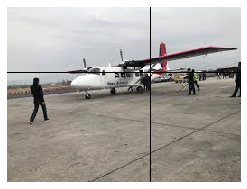

In [7]:
try:
    batch = planes_dataset[3]
    img_tensor = batch['image']
    x = batch['xy'][0]
    y = batch['xy'][1]
    for i in range(0, img_tensor.size()[2]):
        img_tensor[:, y, i] = -1

    for i in range(0, img_tensor.size()[1]):
        img_tensor[:, i, x] = -1    
    
    show_image(img_tensor)
except ValueError:
    print("Oops!  That was no valid number.  Try again...")

In [ ]:
img_tensor.size()

In [ ]:
y

In [ ]:
x

In [ ]:
type(x)

## Network architecture

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# net = SimpleNet().to(device)
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)
net = net.to(device)

In [ ]:
loss_function_xy = torch.nn.L1Loss()
loss_function_bce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## Train

In [ ]:
train_size = int(0.8 * len(planes_dataset))
test_size = len(planes_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(planes_dataset, [train_size, test_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(PlanesDataset(train_set, root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/'), batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(PlanesDataset(test_set, root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/'), batch_size=8, shuffle=False, num_workers=2)

In [ ]:
for epoch in range(10):

    net.train()
    epoch_loss = 0.

    for batch in train_loader:
        images, xy, labels = batch['image'], batch['x'], batch['label'] 
        images = images.to(device)
        xy = xy.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = net(images)

        loss = loss_function_xy(predictions[:, 10:], xy) + loss_function_bce(predictions[:, :10], labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Train: {epoch_loss / len(train_loader)}')

    net.eval()
    epoch_loss = 0.

    for batch in test_loader:
        images, xy, labels = batch['image'], batch['xy'], batch['label'] 
        images = images.to(device)
        xy = xy.to(device)
        labels = labels.to(device)

        predictions = net(images)

        with torch.no_grad():
            loss = loss_function_xy(predictions[:, 10:], xy) + loss_function_bce(predictions[:, :10], labels)

        epoch_loss += loss.item()
    print(f'Test: {epoch_loss / len(test_loader)}')